In [1]:
import torch
import pypose as pp
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt

In [6]:
"""
Utils functions for Pose Graph Optimization
Pose index in plot needs to be adjusted to match the pose index in the graph
"""

def read_file(file_path):
    data = np.loadtxt(file_path, delimiter=' ', skiprows=1)
    return torch.tensor(data).float()

def plot_poses(poses_before, poses_after=None):
    plt.figure(figsize=(10, 8))
    plt.plot(poses_before[:,0], poses_before[:,1], 'bo', label='Before Optimization')
    plt.plot(poses_after[:,0], poses_after[:,1], 'ro', label='After Optimization')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Pose Graph Optimization Results')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

def plot_pose(poses):
    plt.figure(figsize=(10, 8))
    plt.plot(poses[:,0], poses[:,1], 'bo', label='Poses')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Pose Graph Optimization Results')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [23]:
"""
Scale Drift Circle
Use PyPose to optimize a pose graph with scale drift.
"""

class scale_drift(nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.nodes = pp.Parameter(nodes)

    def forward(self, edges):
        node_gt = self.nodes[0].detach().reshape(1,8)
        nodes_from = torch.cat((node_gt, self.nodes[1:,:]), dim=0).Log()
        nodes_to = torch.cat((self.nodes[1:,:], node_gt), dim=0).Log()
        edge_pose = pp.Sim3(edges)
        residual = (nodes_to.Exp() @ nodes_from.Exp().Inv()).Log()
        result = edge_pose.Log() - residual
        return result

edge_path = "data/scale_drift_circle/edges.txt"
node_path = "data/scale_drift_circle/nodes.txt"

nodes = read_file(node_path)[:, 1:]
edges = read_file(edge_path)[:, 2:]

network = scale_drift(pp.Sim3(nodes))
strategy = pp.optim.strategy.Adaptive(damping=1e-6)
optimizer = pp.optim.LM(network, strategy=strategy, kernel=pp.optim.kernel.Huber())
for idx in range(10):
    loss = optimizer.step(edges)
    print(f"Loss: {loss}")

Loss: 0.863567590713501
Loss: 0.02438371814787388
Loss: 0.012063106521964073
Loss: 0.011849971488118172
Loss: 0.011843965388834476
Loss: 0.011843683198094368
Loss: 0.011843668296933174
Loss: 0.011843668296933174
Loss: 0.011843664571642876
Loss: 0.011843636631965637


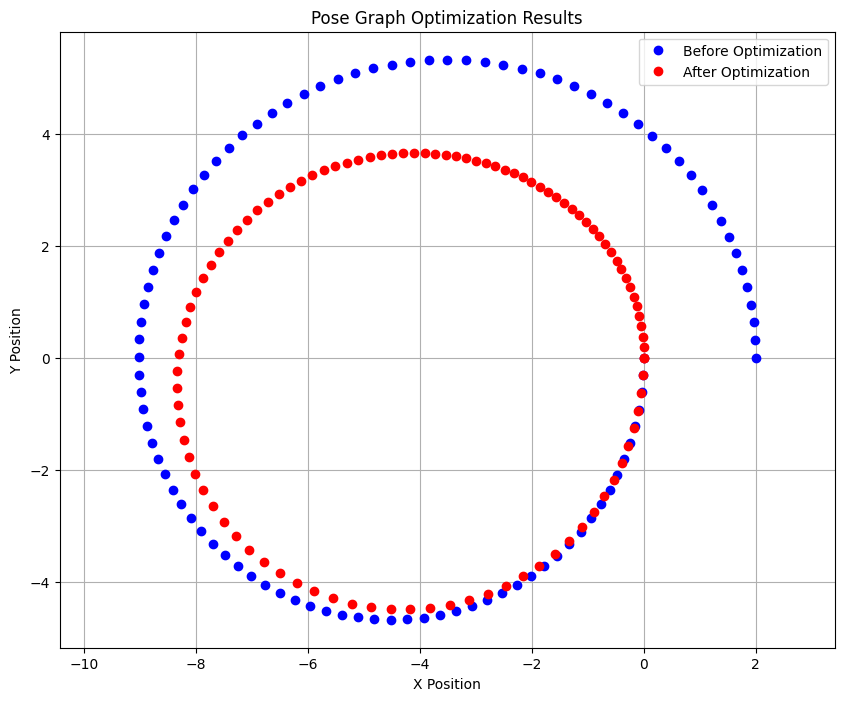

In [8]:
plot_poses(read_file("data/scale_drift_circle/nodes.txt")[:, 1:], 
           nodes.detach())

# Scale-Jump

14
A globally consistent scale can be reconciled.


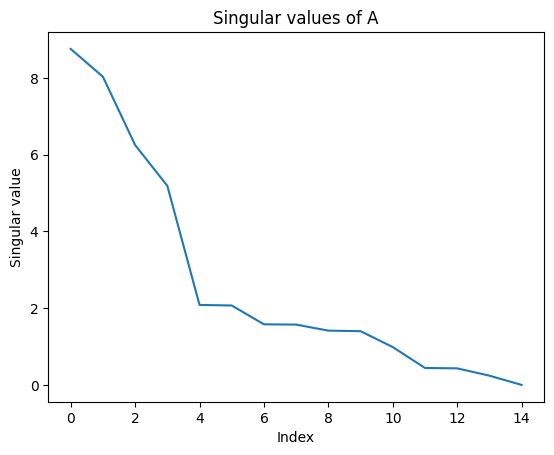

In [ ]:
"""
Determine whether or not can a globally consistent scale be reconciled
"""

nodes_critical = np.loadtxt('data/scale_jump_circle4/nodes_critical.txt', skiprows=1)

B = len(nodes_critical)
N = len(nodes_critical)

A = np.zeros((3 * B + 3, 3 * N + B))

v_k = []
for i in range(len(nodes_critical)):
    s_k = i
    e_k = (i + 1) % len(nodes_critical)
    start_node = nodes_critical[s_k]
    end_node = nodes_critical[e_k]
    
    translation = (end_node[1:4] - start_node[1:4])
    # Fill in the placeholders in the matrix A
    A[3*i:3*(i+1), 3*s_k:3*(s_k+1)] = -np.eye(3)
    A[3*i:3*(i+1), 3*e_k:3*(e_k+1)] = np.eye(3)
    A[3*i:3*(i+1), 3*N+i] = translation
A[-3:, :3] = np.eye(3)


U, singular_values, Vt = np.linalg.svd(A)
full_rank = np.sum(singular_values > 1e-10)

# Compute the rank of A
rank_A = np.linalg.matrix_rank(A)
print(rank_A)
if full_rank - rank_A <= 1:
    print("A globally consistent scale can be reconciled.")
else:
    print("A globally consistent scale cannot be reconciled. The rank deficiency is larger than 1.")

plt.figure()
plt.plot(range(len(singular_values)), singular_values)
plt.title("Singular values of A")
plt.xlabel("Index")
plt.ylabel("Singular value")

plt.show()

In [ ]:
"""
Scale Jump Circle optimization using Hybrid Pose Graph Optimization
"""

class HybridPoseGraphOptimization(nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.nodes = nn.Parameter(nodes) # Initial node parameters

    def forward(self, edges):
        i = 0
        I6 = torch.eye(6, dtype=torch.float32)
        omega = torch.block_diag(I6, torch.tensor([[0.0]]))
        residuals = torch.zeros(len(edges), 7)
        node_first = self.nodes[0].detach().reshape(1,8)
        nodes_from = torch.cat((node_first, self.nodes[1:,:]), dim=0)
        nodes_to = torch.cat((self.nodes[1:,:], node_first), dim=0)
        for edge in edges:
            from_pose = nodes_from[i]
            to_pose = nodes_to[i]
            estimated_T1_inv_T0 = torch.eye(4)

            estimated_T1_inv_T0[:3,:3] = torch.exp(to_pose.scale() - from_pose.scale()) * from_pose.rotation().matrix().T @ to_pose.rotation().matrix()
            estimated_T1_inv_T0[:3, 3] = (torch.exp(-from_pose.scale()) * from_pose.rotation().matrix().T @ (to_pose.translation() - from_pose.translation()).reshape(3,1)).reshape(3)
            estimated_T1_inv_T0 = pp.mat2Sim3(estimated_T1_inv_T0)
            
            constraint_T = pp.Sim3(edge)
            constraint_T = torch.cat([constraint_T.translation(), constraint_T.rotation().euler(), constraint_T.scale()], dim=0)
            T1_inv_T0_vec = torch.cat([estimated_T1_inv_T0.translation(), estimated_T1_inv_T0.rotation().euler(), estimated_T1_inv_T0.scale()], dim=0)

            if edge[7] == -1:
                residuals[i] =  (T1_inv_T0_vec - constraint_T) @ omega
            else:
                residuals[i] = T1_inv_T0_vec - constraint_T
            i += 1
        return residuals

edge_path = "data/scale_jump_circle4/edges.txt"
node_path = "data/scale_jump_circle4/nodes.txt"
gt_path = "data/scale_jump_circle4/GT.txt"

nodes = read_file(node_path)[:, 1:]
edges = read_file(edge_path)[:, 2:]

network = HybridPoseGraphOptimization(pp.Sim3(nodes))
strategy = pp.optim.strategy.Adaptive(damping=1e-6)
optimizer = pp.optim.LM(network, strategy=strategy, kernel=pp.optim.kernel.Huber())
for idx in range(100):
    loss = optimizer.step(edges)
    print(f"Loss: {loss}")

In [ ]:
# Modify the x, y in function if the result is not as expected
plot_pose(nodes.detach())